# Churn de clientes

### O desafio de prever se um cliente irá sair da Base de Clientes Ativos (também conhecido como churn) não é um problema exclusivo do varejo, sendo uma área de estudos constante da maioria das indústrias e empresas de serviços que dependem da retenção.

### Esse é um exemplo do tipo de problema que um cientista do Chapter de Ciência de Dados do Luizalabs entra de cabeça e cujas soluções servem para alavancar várias frentes de trabalho. A solução em si já traz muito valor, se tiver alto índice de acertos pode ser usada para elencar automaticamente clientes com alto risco de churn para uma promoção agressiva com o objetivo retê-lo na base.

### Também há muito valor nos insights e na validação de hipóteses que acontece durante o processo de análise do problema e das soluções. Pode-se verificar através de experimentação que, por exemplo, um cliente que compra exclusivamente em datas especiais ou eventos promocionais tem uma chance menor de ser um churn do que um que compra grandes volumes do mesmo produto.

# Objetivos

### Nesse desafio, construído em uma parceria da Tera e o Luizalabs, o objetivo principal será construir algumas soluções baseadas em machine learning para prever se um dado cliente do e-commerce do Magalu continuará comprando na plataforma em 2020 usando algumas características próprias do cliente e seu histórico de compras no ano anterior. No final, algumas dessas soluções devem ser combinadas em um ensemble para criar uma solução única com o objetivo de alavancar ainda mais os resultados.

### Para que o objetivo principal seja cumprido, será necessário construir uma forma de visualização das soluções criadas e a comparação com o modelo baseline e com o modelo de ensemble criados no processo. O formato sugerido é um tabela de resultados contendo as métricas de sucesso de cada modelo criado.

### O objetivo secundário é o levantamento de hipóteses e insights que surgirem durante as experimentações. É interessante fazer isso desde o início como parte da análise exploratória, documentando qualquer indício de informação nova sobre o problema. Também é uma boa prática avaliar os modelos treinados, seja através da exploração de seus parâmetros (por exemplo, os pesos de um modelo linear) ou usando técnicas avançadas como o SHAP.

# Importando bibliotecas

In [1]:
!pip install -U scikit-learn

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando os bancos de dados

In [2]:
# Data set de treino

df_treino = pd.read_csv('C:/Users/55419/Desktop/tera/Conteudo curso DC/Desafio Luisa Labs/client.train.csv')
df_treino.head()

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [3]:
# Data set de teste

df_teste = pd.read_csv('C:/Users/55419/Desktop/tera/Conteudo curso DC/Desafio Luisa Labs/client.test.csv')
df_teste.head()

,client_id,birthdate,state,gender,is_churn
0,cx06840,1982-12-03,st15,cg1,False
1,cx01931,1979-05-09,st15,cg1,False
2,cx35431,1965-05-09,st15,cg1,False
3,cx36233,1954-03-15,st15,cg2,False
4,cx13540,1965-06-19,st15,cg1,False


In [4]:
# Data set desafio

df_desafio = pd.read_csv('C:/Users/55419/Desktop/tera/Conteudo curso DC/Desafio Luisa Labs/client.challenge.data.csv')
df_desafio.head()

,client_id,birthdate,state,gender
0,cx12525,1932-04-19,st15,cg1
1,cx32280,1983-03-01,st15,cg1
2,cx00471,1964-08-30,st15,cg2
3,cx18876,1971-04-27,st15,cg2
4,cx38255,1958-01-26,st15,cg1


In [5]:
# Data set de produtos

produtos = pd.read_csv('C:/Users/55419/Desktop/tera/Conteudo curso DC/Desafio Luisa Labs/product.csv')
produtos.head()

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
3,px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
4,px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218


In [6]:
# Data set de vendas

vendas = pd.read_csv('C:/Users/55419/Desktop/tera/Conteudo curso DC/Desafio Luisa Labs/orders.csv')
vendas.head()

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
3,ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
4,ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.0,pm05,NaN,NaN,st07,dv9,sc08


# Análise exploratória

## EDA DB treino

In [7]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7764 entries, 0 to 7763
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  7764 non-null   object
 1   birthdate  7764 non-null   object
 2   state      7764 non-null   object
 3   gender     7764 non-null   object
 4   is_churn   7764 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 250.3+ KB


In [8]:
df_treino.describe()

,client_id,birthdate,state,gender,is_churn
count,7764,7764,7764,7764,7764
unique,7764,6252,25,2,2
top,cx06840,1990-01-01,st15,cg1,False
freq,1,18,2723,4241,6368


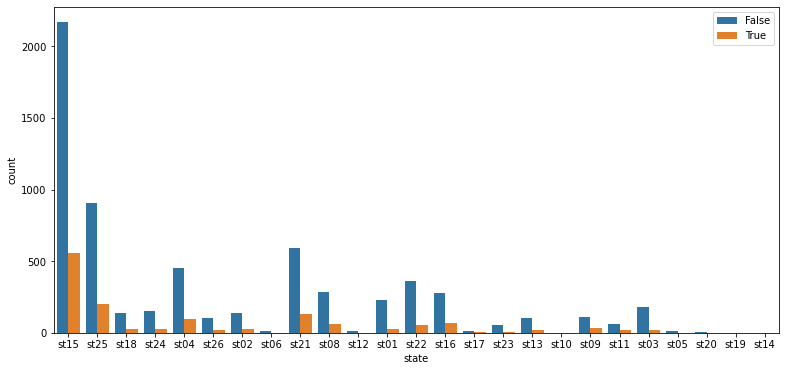

In [9]:
plt.figure(figsize=(13,6))
sns.countplot(x='state', data=df_treino, hue='is_churn')
plt.legend(loc='upper right')

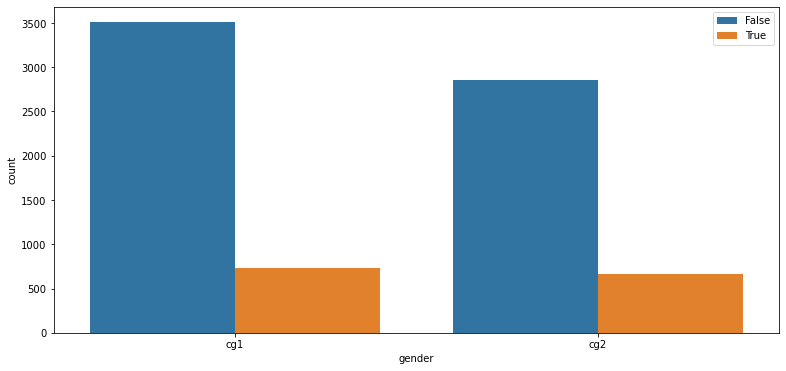

In [10]:
plt.figure(figsize=(13,6))
sns.countplot(x='gender',data=df_treino,hue='is_churn')
plt.legend(loc='upper right')

Criando uma nova coluna com o ano de nascimento do cliente, para poder avaliar a distribuição dos clientes por ano de nascimento

In [11]:
df_treino['birthdate'] = pd.to_datetime(df_treino['birthdate']).dt.date
df_treino['birthdate'] = pd.to_datetime(df_treino['birthdate'], format='%Y/%m/%d')

df_treino['ano_nasc'] = df_treino['birthdate'].dt.year

<AxesSubplot:xlabel='ano_nasc', ylabel='Count'>

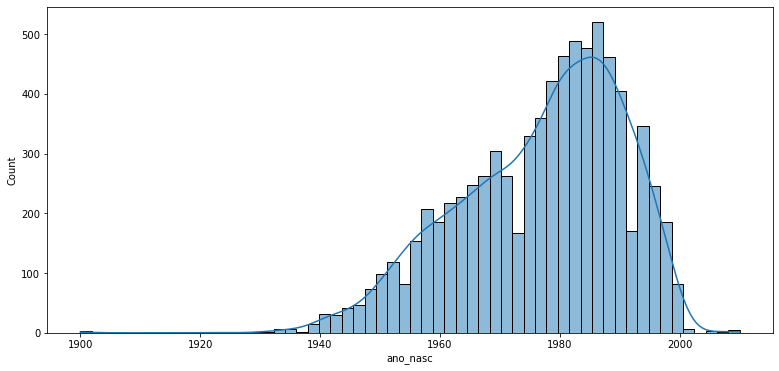

In [12]:
plt.figure(figsize=(13,6))
sns.histplot(x=df_treino.ano_nasc, kde=True)

<AxesSubplot:xlabel='ano_nasc', ylabel='count'>

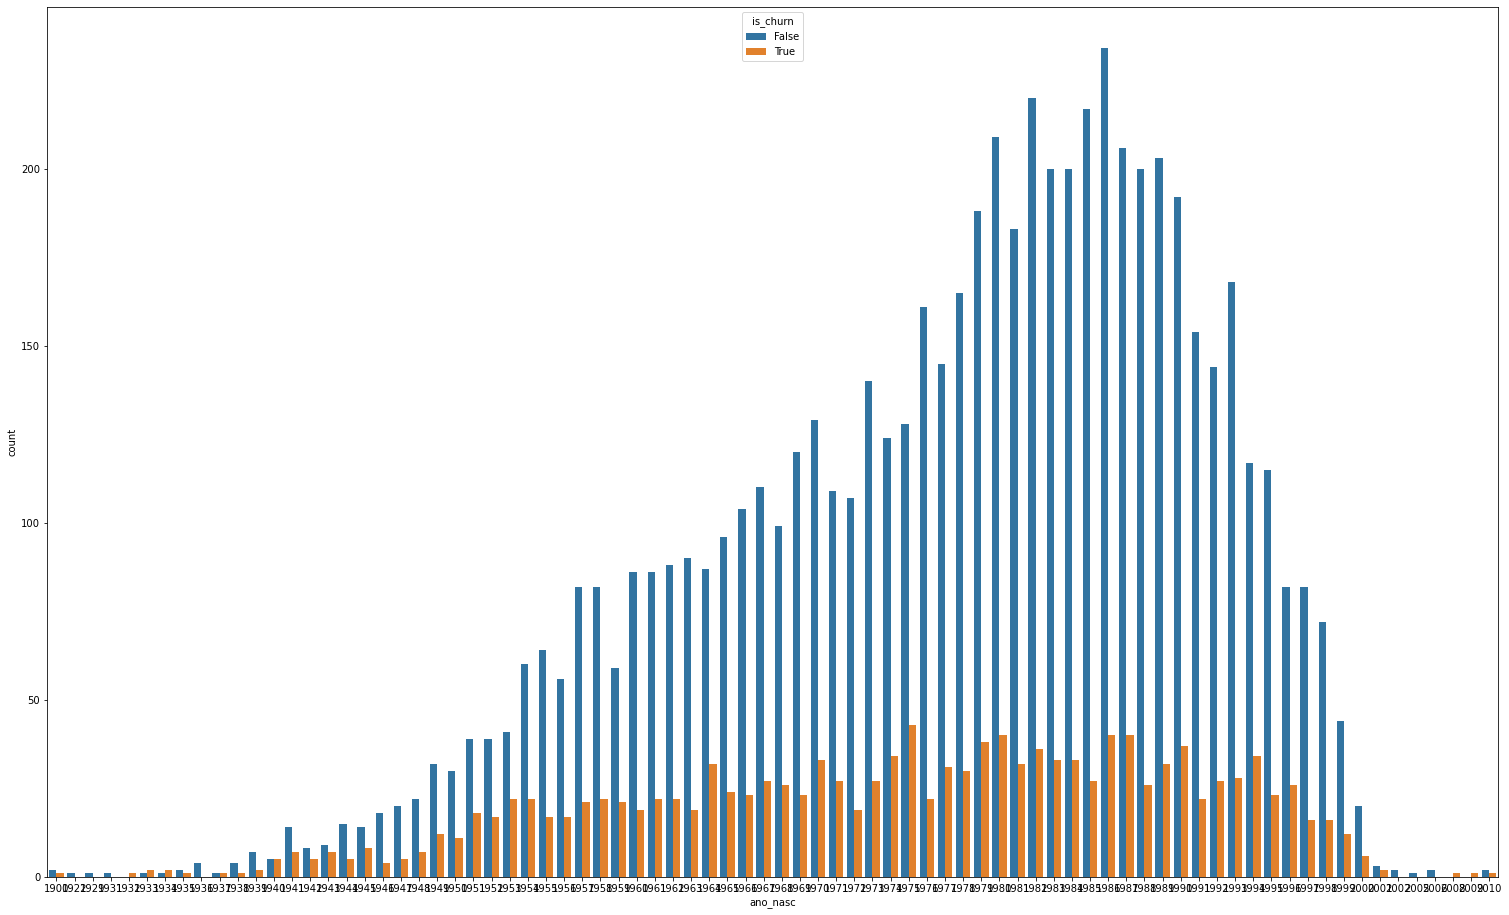

In [13]:
plt.figure(figsize=(26,16))
sns.countplot(x='ano_nasc', data=df_treino, hue='is_churn')

É possivel observar que a curva de churn não acompanha a curva de ano de nascimento

<AxesSubplot:xlabel='is_churn', ylabel='ano_nasc'>

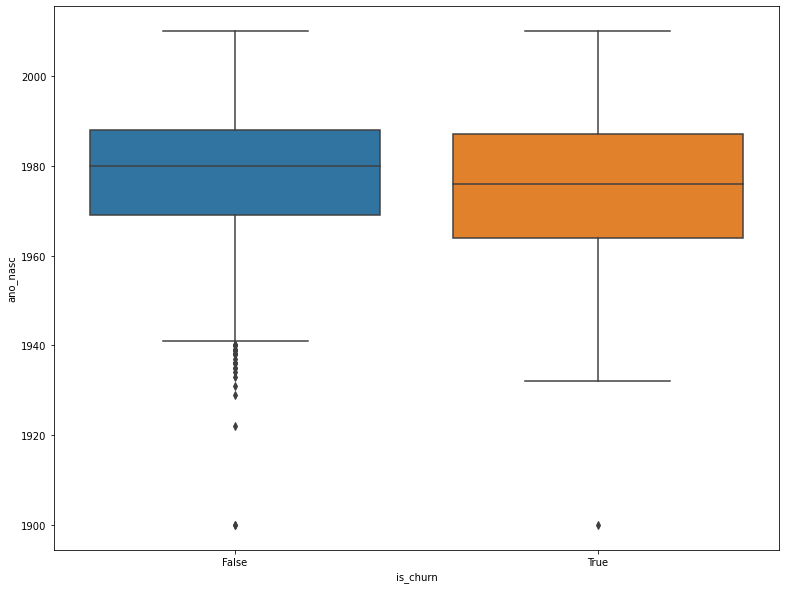

In [14]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df_treino, y='ano_nasc', x="is_churn")

É possivel observar que temos clientes nascidos em 1900, tanto para churn true quanto para false, além disso pode-se observar clientes nascidos em 2010, ou seja menores de idade. 

In [15]:
df_treino.ano_nasc.describe()

count    7764.000000
mean     1976.912931
std        13.633605
min      1900.000000
25%      1968.000000
50%      1979.000000
75%      1987.000000
max      2010.000000
Name: ano_nasc, dtype: float64

<AxesSubplot:xlabel='is_churn', ylabel='count'>

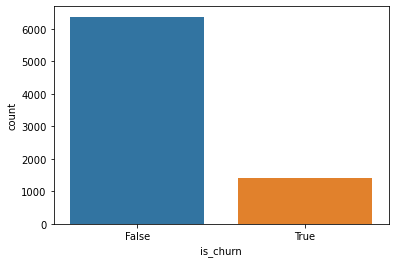

In [16]:
sns.countplot(x='is_churn', data=df_treino)

É possivel observar um certo desbalanceamento no data set de treino, temos algo prox. de 6500 clientes com a tag false, e 1500 com a tag true, isso pode gerar um problema na hora da modelagem do algoritimo de ML.

## EDA DB produtos

In [17]:
produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12659 entries, 0 to 12658
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    12659 non-null  object
 1   category_lv0  12659 non-null  object
 2   category_lv1  12659 non-null  object
 3   category_lv2  12659 non-null  object
 4   category_lv3  12659 non-null  object
 5   category_lv4  12659 non-null  object
dtypes: object(6)
memory usage: 593.5+ KB


In [18]:
produtos.describe(include='object')

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
count,12659,12659,12659,12659,12659,12659
unique,12659,52,296,893,1218,10763
top,px01237,mk17,mk21:089,mk03:092:378,mk03:092:378:103,mk35:072:177:182:09721
freq,1,1273,563,237,237,10


Este DB traz todos os produtos, onde o ID é o identificador unico do produto, o category_lv0 é uma categoria generalizada, como por exemplo, vestuário, a category_lv1 seria camisa e as outras categorias seriam ainda mais específicas. É possivel obserbar que temos mais de 12 mil produtos, sendo assim, é interessante trabalharmos com eles em alguma categoria. A categoria lv4 é tão específica que conta com aprox. 10 mil produtos unicos, enquanto a lv0, conta com apenas 52 produtos unicos, ou seja é mais geral.

<AxesSubplot:xlabel='category_lv0', ylabel='Count'>

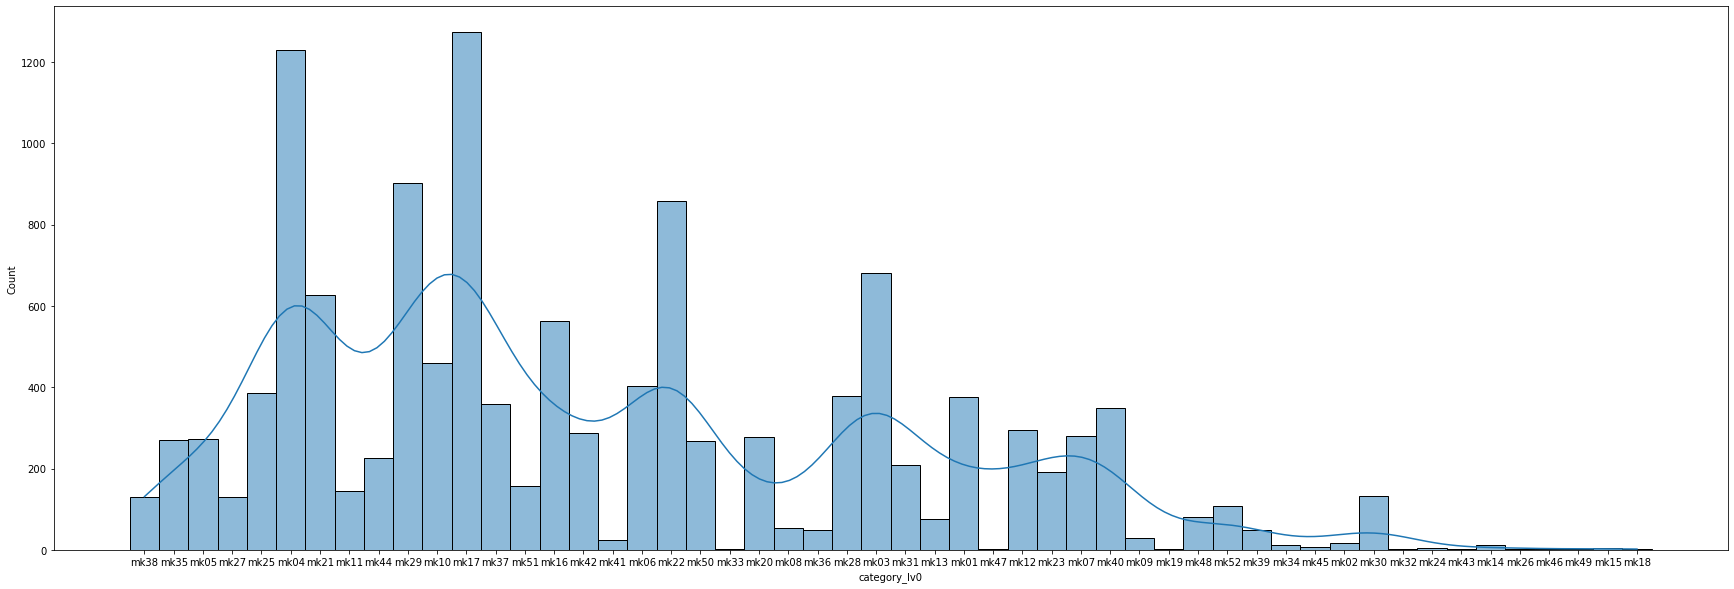

In [19]:
plt.figure(figsize=(30,10))
sns.histplot(x=produtos.category_lv0, kde=True)

# EDA DB vendas

In [20]:
vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168472 entries, 0 to 168471
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
dtypes: float64(4), object(8)
memory usage: 15.4+ MB


Vemos que temos bastante dados faltantes em installments e delivery days. Installments se refere à quantidade de parcelas da compra, uma hipótese para os dados faltantes é que eles sejam referentes as compras realizadas sem parcelamento, ou seja, este valor é 1. Jápara delivery days, os valores faltantes pode ser por conta de compras realizadas e entregues no mesmo dias, sendo assim, este valor seria 0.

In [21]:
vendas.installments.value_counts()

1.0     14451
10.0     5700
2.0      3726
3.0      3064
4.0      2431
5.0      1826
6.0      1309
12.0      894
8.0       734
24.0      726
7.0       688
9.0       470
15.0      113
20.0       89
11.0       86
18.0       65
16.0       42
14.0       38
13.0       27
19.0       24
17.0       16
23.0       13
22.0        8
21.0        5
Name: installments, dtype: int64

<AxesSubplot:xlabel='installments'>

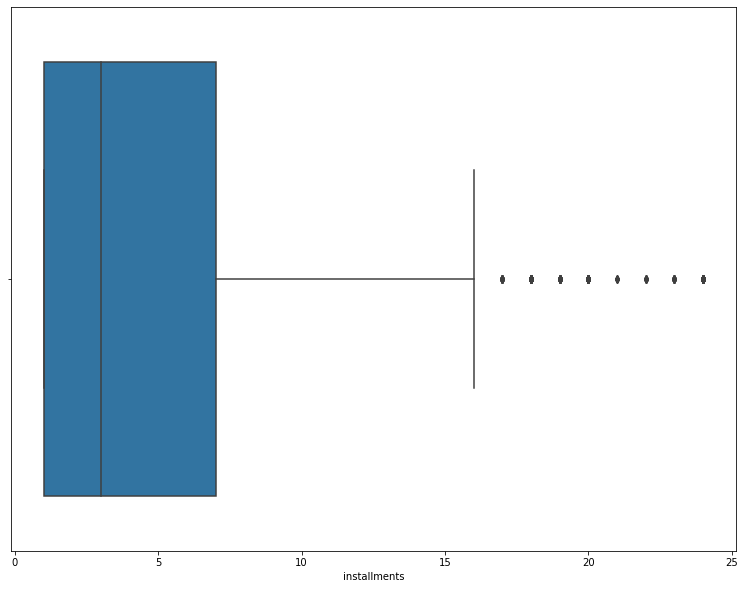

In [22]:
plt.figure(figsize=(13,10))
sns.boxplot(data=vendas, x='installments')

In [23]:
vendas.delivery_days.value_counts()

2.0      22493
6.0       7450
5.0       7217
4.0       5491
7.0       5417
         ...  
67.0         2
63.0         2
59.0         2
69.0         1
165.0        1
Name: delivery_days, Length: 71, dtype: int64

<AxesSubplot:xlabel='delivery_days'>

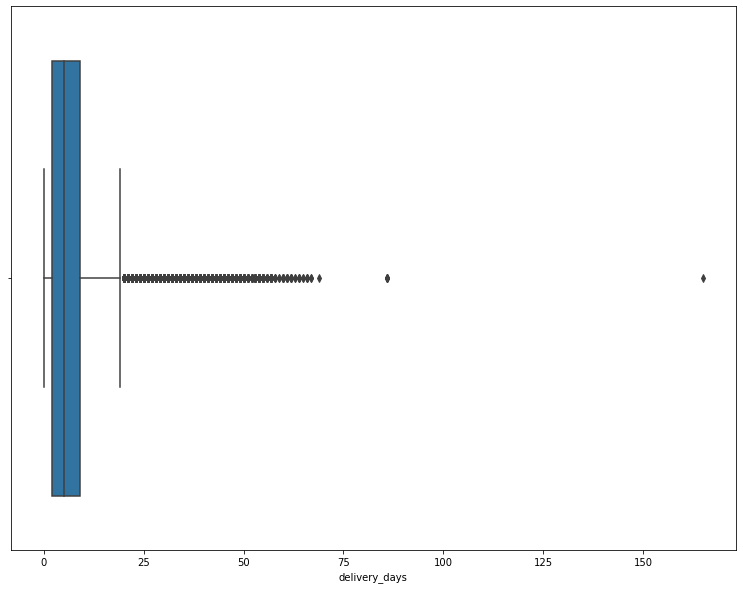

In [24]:
plt.figure(figsize=(13,10))
sns.boxplot(data=vendas, x='delivery_days')

Vemos entregas que que levaram muitos dias para serem entregues, outliers. Porém para o estudo de churn, acredito que esses outliers sejam extremamentes relevantes.

In [25]:
vendas.describe()

,units,price,installments,delivery_days
count,168472.000000,168472.000000,36545.000000,89642.000000
mean,1.228846,451.384291,4.551293,7.017938
std,1.504511,857.769280,4.704385,6.855334
min,0.000000,-8999.000000,1.000000,0.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,162.580000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000
max,110.000000,25648.900000,24.000000,165.000000


<AxesSubplot:xlabel='units'>

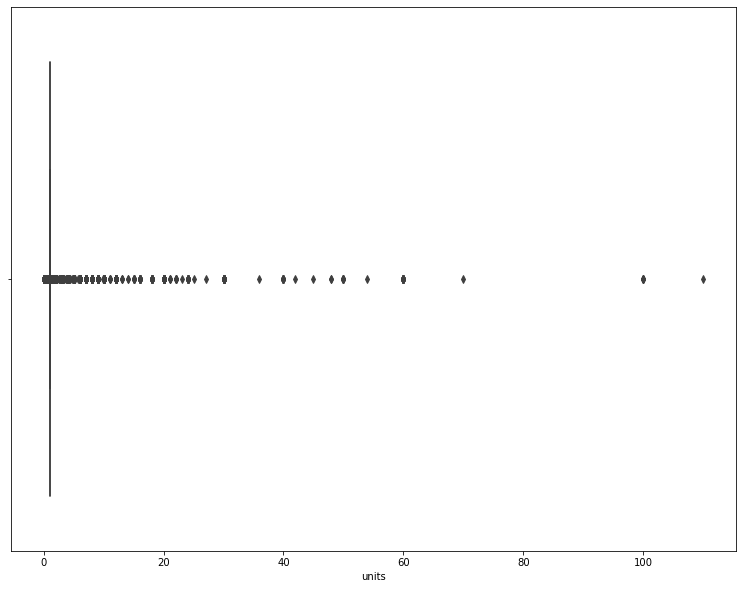

In [26]:
plt.figure(figsize=(13,10))
sns.boxplot(data=vendas, x='units')

É possivel observar compras com mais de 100 itens, e compras de 0 itens, este ultimo é algo estranho, ainda não tive nenhuma ideia do que se trata. Já compras com muitos itens, pode ser por conta que o produto é vendido em uma unidade de medida diferente de unidades ou peças, como por exemplo, kilos ou metros.

<AxesSubplot:xlabel='price'>

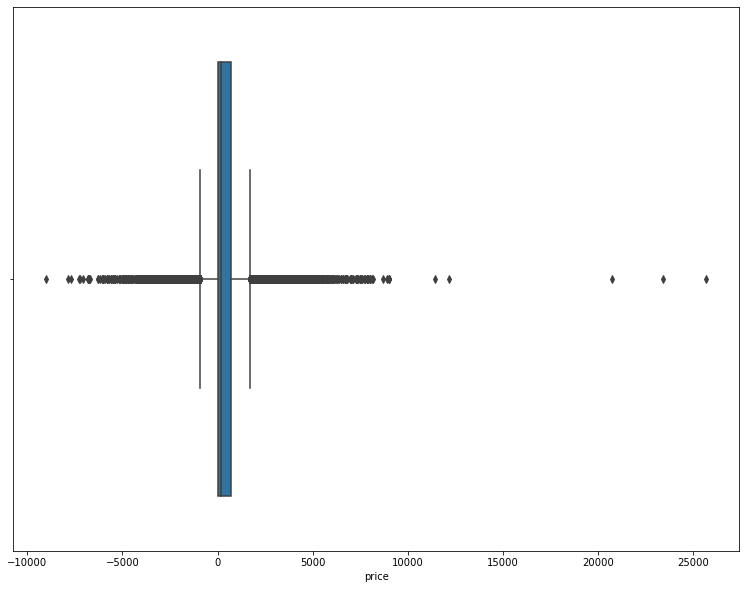

In [27]:
plt.figure(figsize=(13,10))
sns.boxplot(data=vendas, x='price')

É possivel observar valores negativos para preços, o que poderia ser referente à uma devolução.

In [28]:
vendas.describe(include='object')

,order_id,client_id,product_id,datetime,payment_method,delivery_state,device,source
count,168472,168472,168472,168472,168472,168472,168472,168472
unique,133209,38821,12535,102263,14,26,9,16
top,ox059501,cx33292,px10485,2019-11-29 10:29:00,pm05,st07,dv9,sc08
freq,5,101,1875,41,131927,97820,97794,97796


<AxesSubplot:xlabel='payment_method', ylabel='Count'>

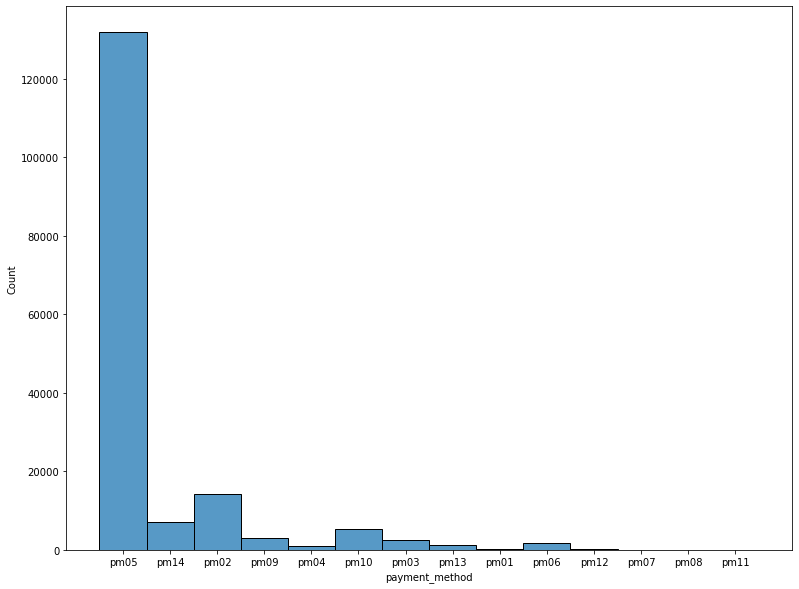

In [29]:
plt.figure(figsize=(13,10))
sns.histplot(x=vendas.payment_method)

<AxesSubplot:xlabel='delivery_state', ylabel='Count'>

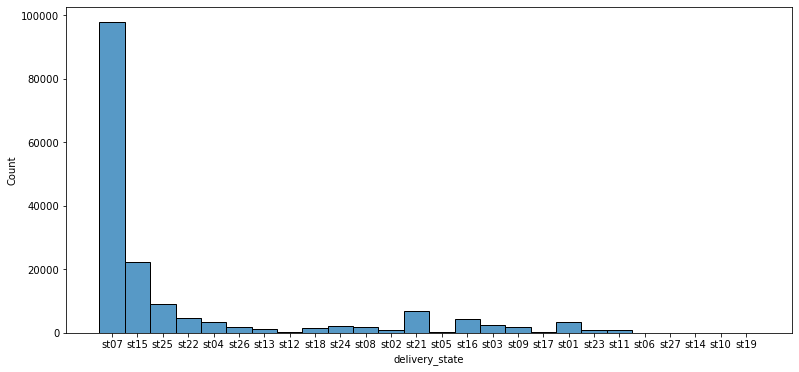

In [30]:
plt.figure(figsize=(13,6))
sns.histplot(x=vendas.delivery_state)

<AxesSubplot:xlabel='device', ylabel='Count'>

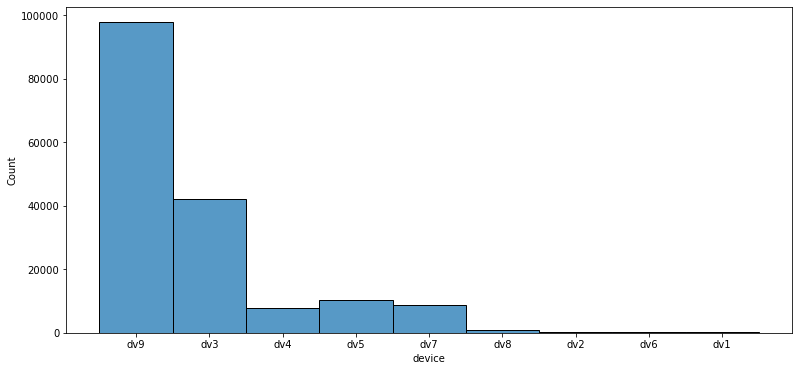

In [31]:
plt.figure(figsize=(13,6))
sns.histplot(x=vendas.device)

<AxesSubplot:xlabel='source', ylabel='Count'>

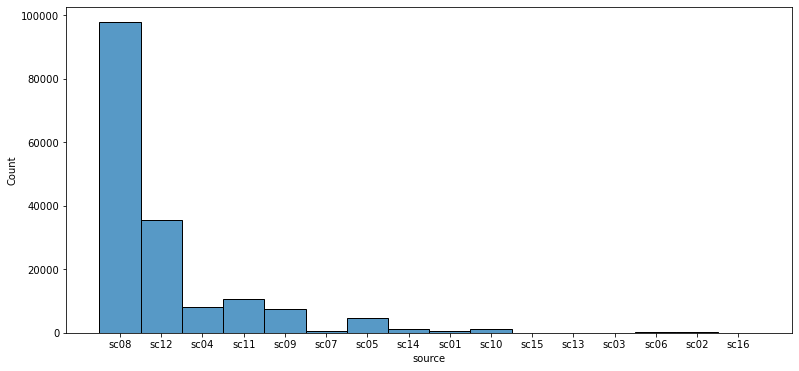

In [32]:
plt.figure(figsize=(13,6))
sns.histplot(x=vendas.source)

# Juntando os DB

In [33]:
df_1 = pd.merge(df_treino, vendas, on="client_id")

In [34]:
df = pd.merge(df_1, produtos, on="product_id")

In [35]:
df.head()

,client_id,birthdate,state,gender,is_churn,ano_nasc,order_id,product_id,datetime,units,...,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,cx06840,1982-12-03,st15,cg1,False,1982,ox061137,px07033,2019-01-19 13:09:00,1.0,...,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:256,mk05:072:256:182,mk05:072:256:182:09643
1,cx25248,1968-06-12,st15,cg1,False,1968,ox073738,px07033,2019-01-17 11:34:00,1.0,...,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:256,mk05:072:256:182,mk05:072:256:182:09643
2,cx06840,1982-12-03,st15,cg1,False,1982,ox061137,px05992,2019-01-19 13:09:00,3.0,...,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:056,mk05:072:056:182,mk05:072:056:182:07587
3,cx33791,1990-05-23,st15,cg1,True,1990,ox102977,px05992,2019-03-01 10:28:00,1.0,...,NaN,NaN,st07,dv9,sc08,mk05,mk05:072,mk05:072:056,mk05:072:056:182,mk05:072:056:182:07587
4,cx06840,1982-12-03,st15,cg1,False,1982,ox038612,px10040,2019-04-18 14:36:00,1.0,...,NaN,NaN,st07,dv9,sc08,mk17,mk17:251,mk17:251:555,mk17:251:555:070,mk17:251:555:070:01336


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33860 entries, 0 to 33859
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       33860 non-null  object        
 1   birthdate       33860 non-null  datetime64[ns]
 2   state           33860 non-null  object        
 3   gender          33860 non-null  object        
 4   is_churn        33860 non-null  bool          
 5   ano_nasc        33860 non-null  int64         
 6   order_id        33860 non-null  object        
 7   product_id      33860 non-null  object        
 8   datetime        33860 non-null  object        
 9   units           33860 non-null  float64       
 10  price           33860 non-null  float64       
 11  payment_method  33860 non-null  object        
 12  installments    7321 non-null   float64       
 13  delivery_days   17966 non-null  float64       
 14  delivery_state  33860 non-null  object        
 15  de

In [37]:
df.describe()

,ano_nasc,units,price,installments,delivery_days
count,33860.000000,33860.000000,33860.000000,7321.000000,17966.000000
mean,1977.310071,1.233961,458.337521,4.558257,7.094401
std,13.616812,1.539891,863.254420,4.673074,6.902276
min,1900.000000,0.000000,-6682.680000,1.000000,0.000000
25%,1968.000000,1.000000,39.900000,1.000000,2.000000
50%,1980.000000,1.000000,159.995000,2.000000,5.000000
75%,1988.000000,1.000000,700.000000,8.000000,9.000000
max,2010.000000,100.000000,20699.100000,24.000000,63.000000


# Análise bivariada

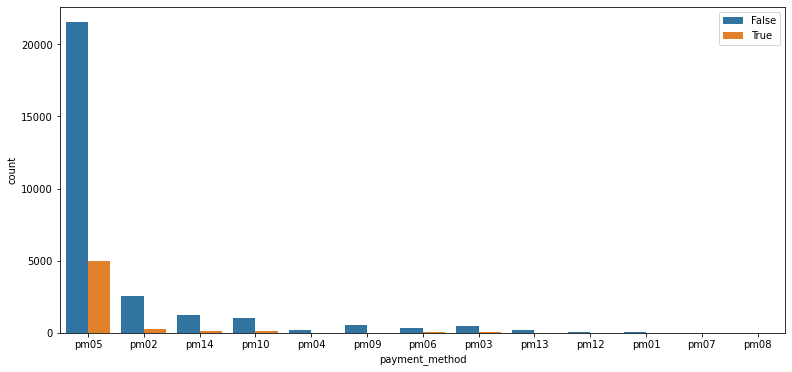

In [38]:
plt.figure(figsize=(13,6))
sns.countplot(x='payment_method', data=df, hue='is_churn')
plt.legend(loc='upper right')

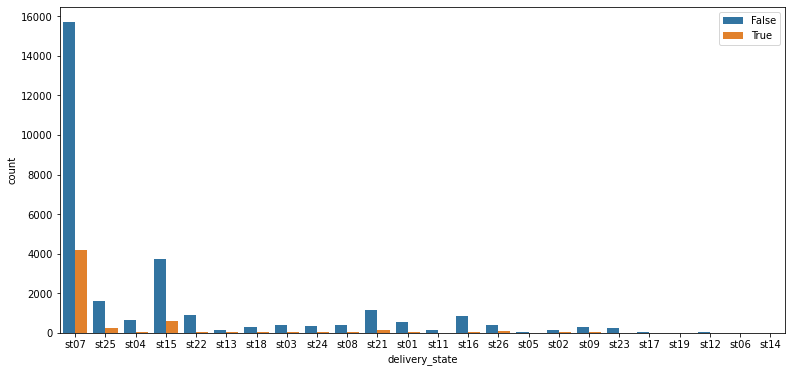

In [39]:
plt.figure(figsize=(13,6))
sns.countplot(x='delivery_state', data=df, hue='is_churn')
plt.legend(loc='upper right')

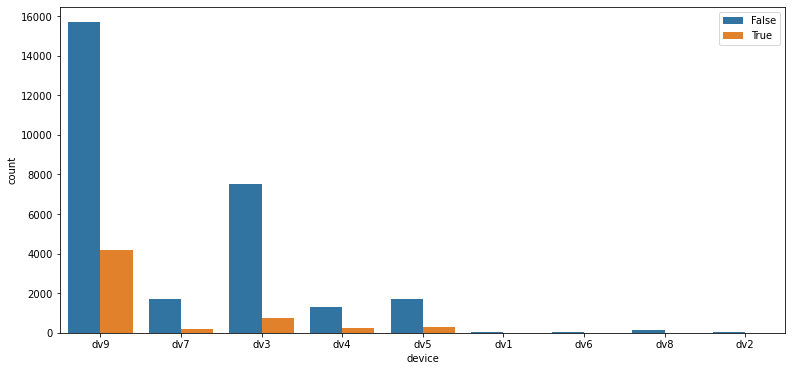

In [40]:
plt.figure(figsize=(13,6))
sns.countplot(x='device', data=df, hue='is_churn')
plt.legend(loc='upper right')

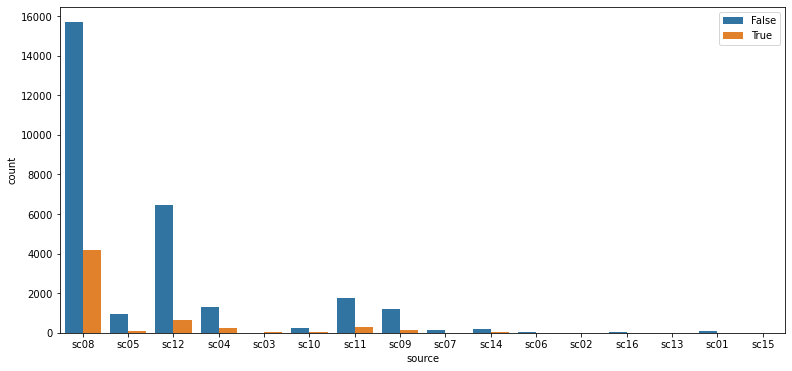

In [41]:
plt.figure(figsize=(13,6))
sns.countplot(x='source', data=df, hue='is_churn')
plt.legend(loc='upper right')

<AxesSubplot:xlabel='is_churn', ylabel='installments'>

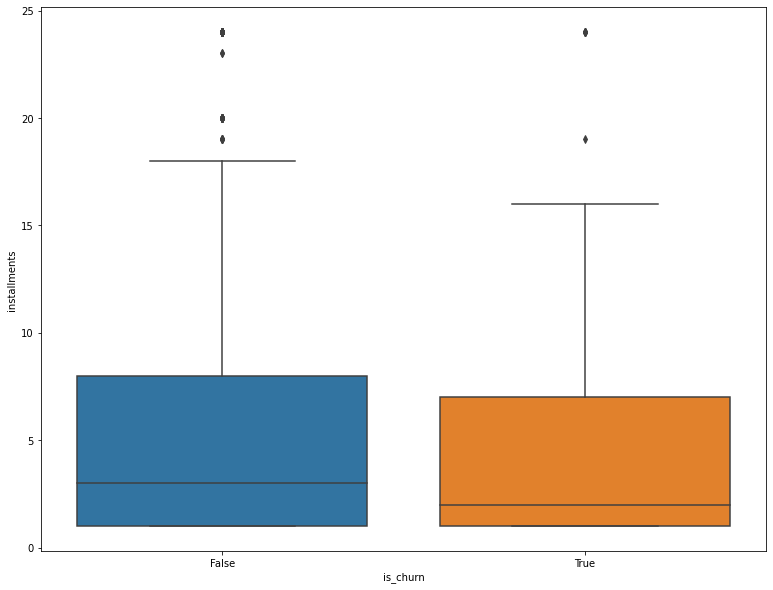

In [42]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='installments', x='is_churn')

<AxesSubplot:xlabel='is_churn', ylabel='delivery_days'>

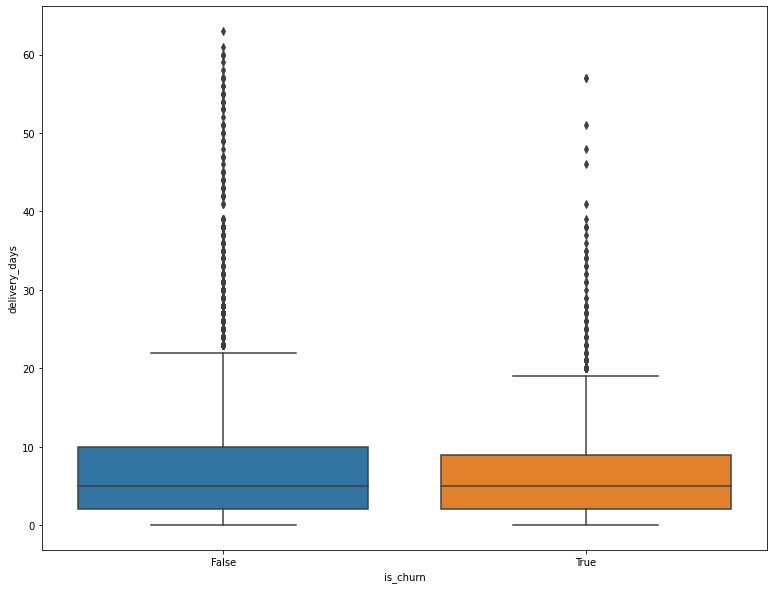

In [43]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='delivery_days', x='is_churn')

<AxesSubplot:xlabel='is_churn', ylabel='units'>

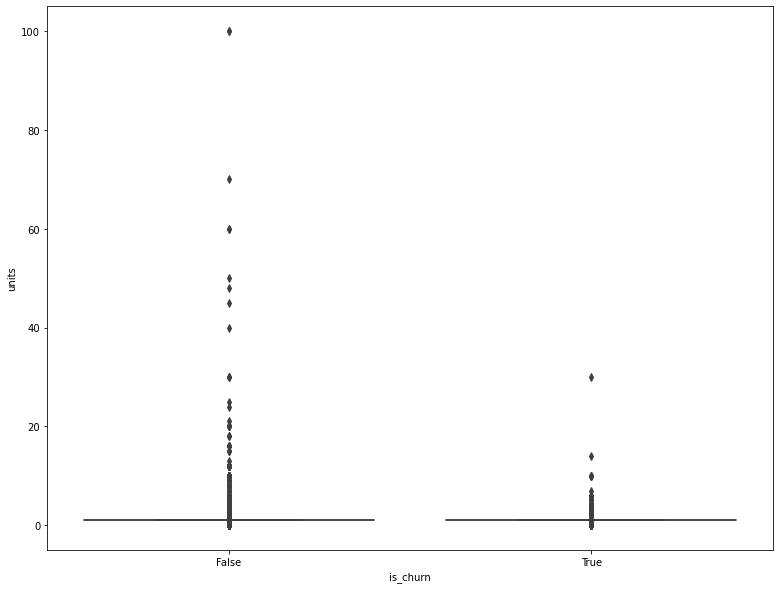

In [44]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='units', x='is_churn')

<AxesSubplot:xlabel='is_churn', ylabel='price'>

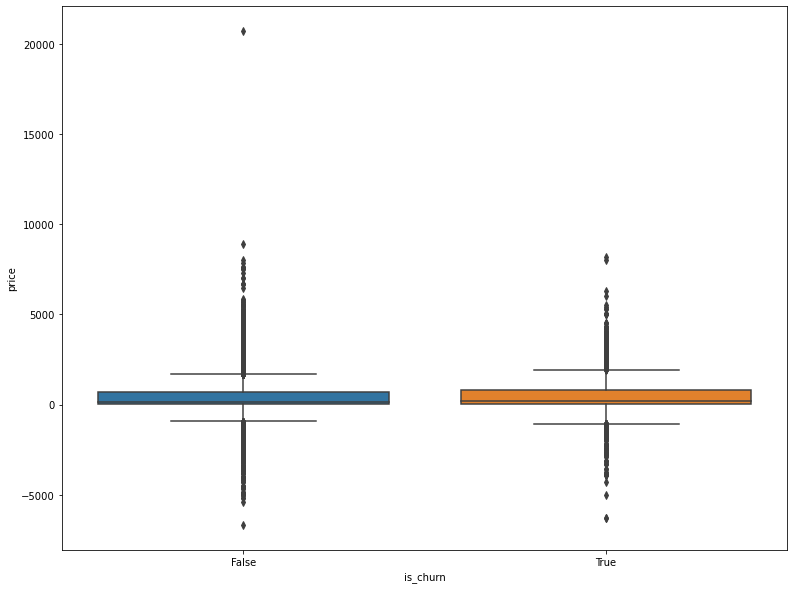

In [45]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='price', x='is_churn')

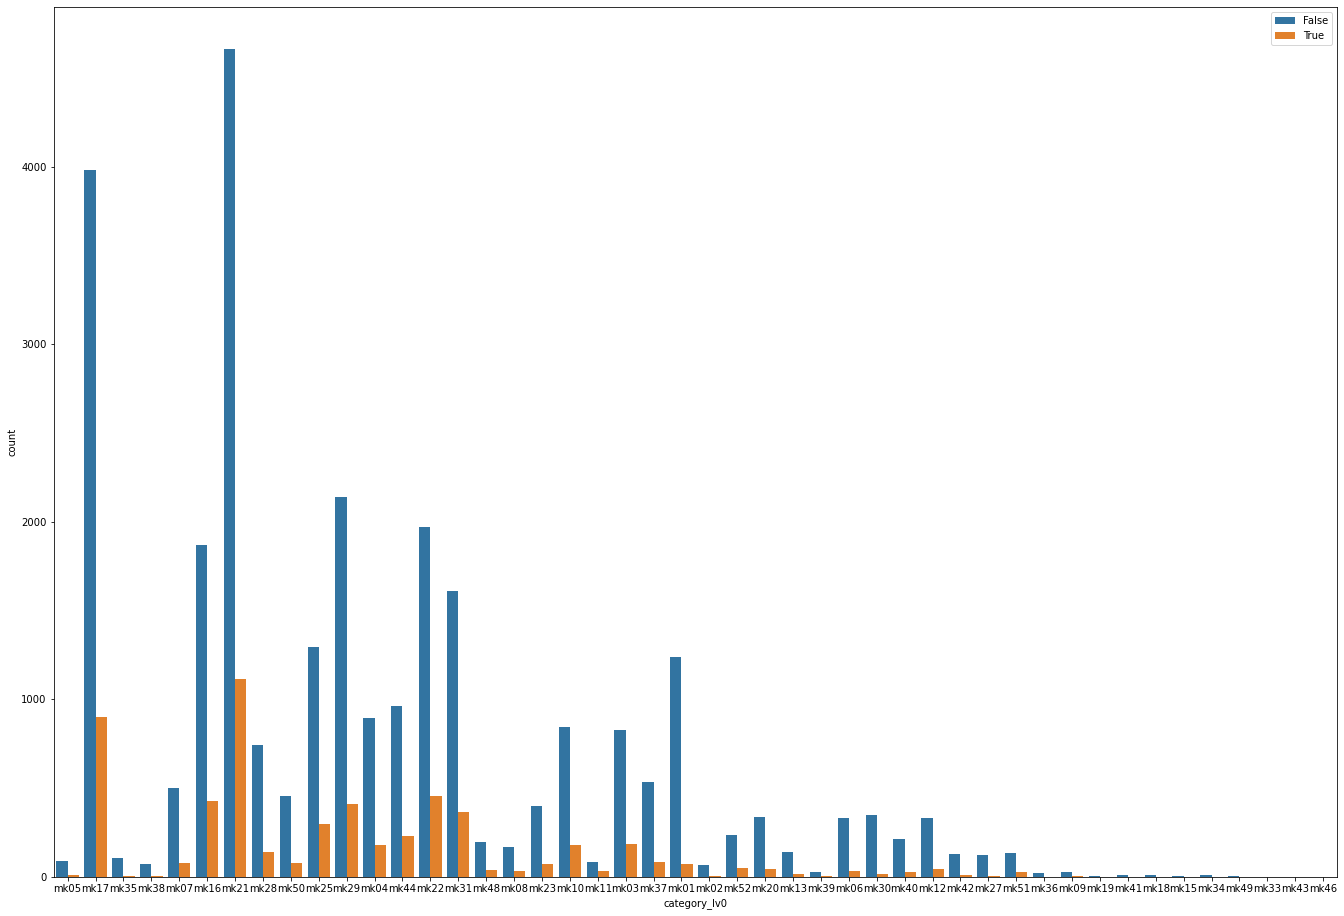

In [46]:
plt.figure(figsize=(23,16))
sns.countplot(x='category_lv0', data=df, hue='is_churn')
plt.legend(loc='upper right')

# Teste de hipótese

## Teste qui-quadrado para avaliar se há relação entre genero e churn.

 Para este teste irei utilizar o DB sem dados duplicados, ou seja, irei realizar este teste de hipótese considerando apenas se o cliente deu churn ou não, desconsiderando os dados de recompra deste cliente, pois assim estou realizando um teste que leva em conta apenas o genero. Caso eu optasse por utilizar o banco de dados com as varias compras realizadas pelo cliente no periodo de extração dos dados, eu poderia influenciar meu teste com base na recompra dos clientes, basicamente estou dizendo que pode existir uma hipótese que clientes "x" recompram mais que clientes "y", e isso influenciaria no meu teste de hipótese, que tem por objetivo analisar apenas a influencia do genero na variavel resposta "is_churn".

H0 = não há relação

H1 = há relação

In [47]:
df_hip_1 = df.copy()
df_hip_1 = df_hip_1.drop_duplicates('client_id')

In [48]:
from scipy.stats import chi2_contingency

crosstab = pd.crosstab(df_hip_1['gender'],
                      df_hip_1['is_churn'])

stat, p,df_hip_1, expected = chi2_contingency(crosstab)
print('stat = %.3f, p = %.3f' % (stat,p))

stat = 3.182, p = 0.074


Como p-valor é superior à 0.05, pode-se dizer que não há diferença estatística entre genero e churn.

## Teste qui-quadrado para idade e churn.

Para este teste é preciso criar uma faixa etária, e para isso utilizarei o ano de nascimento do cliente. Também irei seguir na mesma linha de pensamentodo teste anterior, ou seja, utilizarei o banco de dados sem as diversas compras do cliente no periodo de extração dos dados.

H0 = não há relação entre idade e churn

H1 = há relação entre idade e churn

In [49]:
df_hip_2 = df.copy()
df_hip_2['idade'] = 2019 - df_hip_2['ano_nasc']

In [50]:
crosstab = pd.crosstab(df_hip_2['idade'],
                      df_hip_2['is_churn'])

stat, p,df_hip_2, expected = chi2_contingency(crosstab)
print('stat = %.3f, p = %.3f' % (stat,p))

stat = 985.605, p = 0.000


Como p-valor é inferior à 0.05, pode-se dizer que há diferença estatistica entre idade e churn. Isto é até esperado, tendo em vista que pessoas mais velhas tendem à morrer, e consequentemente irão parar de comprar na minha loja, e automaticamente irão estar marcadas como churn no meus dados.

# Feature Engineering

In [51]:
# Criando a variavel idade
df['idade'] = 2019 - df.ano_nasc

# Criando a variavel mês da compra
df['datetime'] = pd.to_datetime(df['datetime']).dt.date
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d')
df['mes_compra'] = df['datetime'].dt.month

# Criando a variavel unidades compradas
teste = df[['order_id', 'units']].groupby('order_id').sum().reset_index()
df = pd.merge(teste, df, on="order_id")
df = df.rename(columns = {'units_x' : 'soma_units'})
df = df.drop('units_y', axis=1)

# Explorando as novas features

<AxesSubplot:xlabel='is_churn', ylabel='soma_units'>

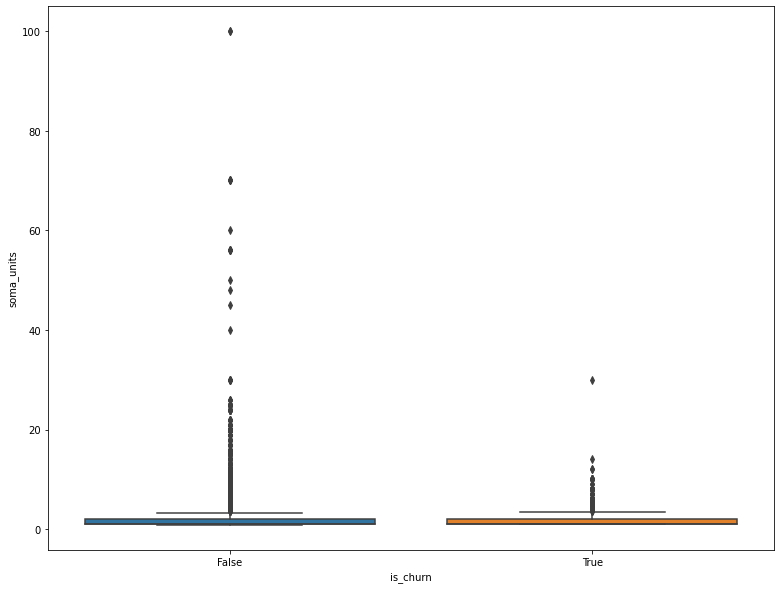

In [52]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='soma_units', x='is_churn')

<AxesSubplot:xlabel='is_churn', ylabel='idade'>

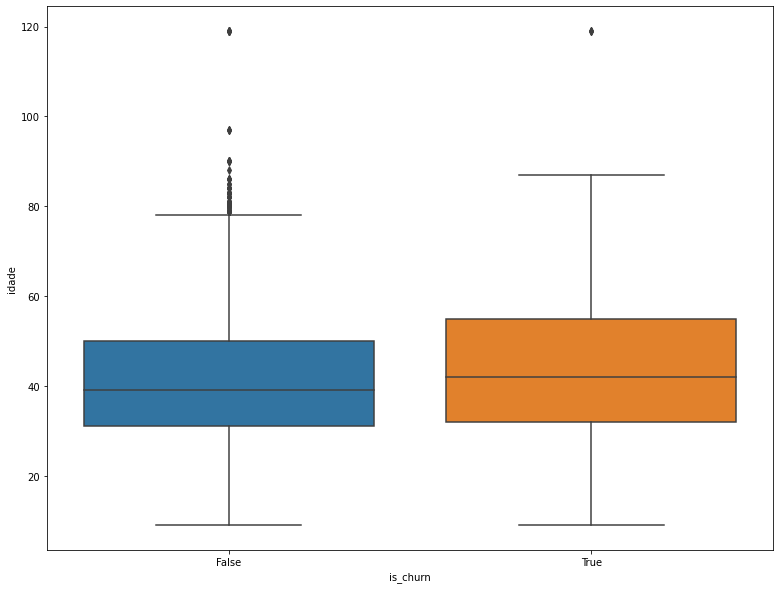

In [53]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='idade', x='is_churn')

<AxesSubplot:xlabel='is_churn', ylabel='mes_compra'>

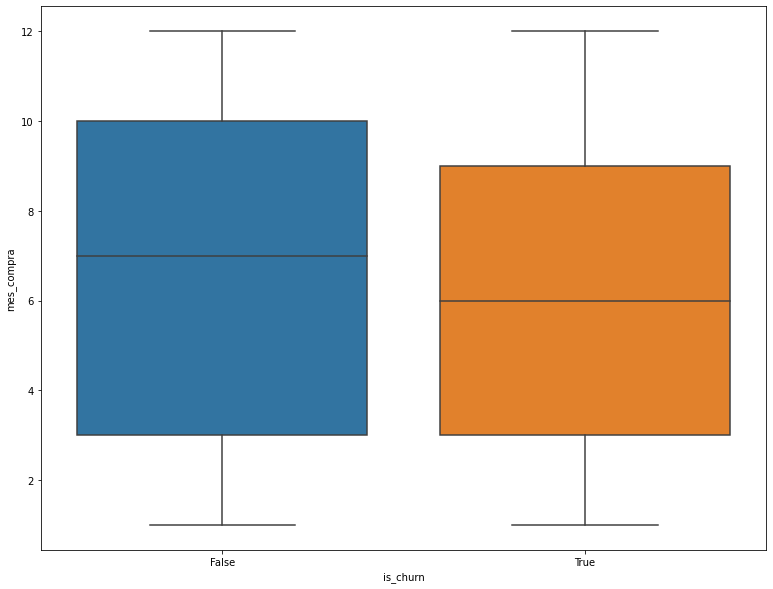

In [54]:
plt.figure(figsize=(13,10))
sns.boxplot(data=df, y='mes_compra', x='is_churn')

# Pré processamento dos dados

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33860 entries, 0 to 33859
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        33860 non-null  object        
 1   soma_units      33860 non-null  float64       
 2   client_id       33860 non-null  object        
 3   birthdate       33860 non-null  datetime64[ns]
 4   state           33860 non-null  object        
 5   gender          33860 non-null  object        
 6   is_churn        33860 non-null  bool          
 7   ano_nasc        33860 non-null  int64         
 8   product_id      33860 non-null  object        
 9   datetime        33860 non-null  datetime64[ns]
 10  price           33860 non-null  float64       
 11  payment_method  33860 non-null  object        
 12  installments    7321 non-null   float64       
 13  delivery_days   17966 non-null  float64       
 14  delivery_state  33860 non-null  object        
 15  de

In [56]:
df.installments.fillna(1, inplace=True)
df.delivery_days.fillna(0, inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33860 entries, 0 to 33859
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        33860 non-null  object        
 1   soma_units      33860 non-null  float64       
 2   client_id       33860 non-null  object        
 3   birthdate       33860 non-null  datetime64[ns]
 4   state           33860 non-null  object        
 5   gender          33860 non-null  object        
 6   is_churn        33860 non-null  bool          
 7   ano_nasc        33860 non-null  int64         
 8   product_id      33860 non-null  object        
 9   datetime        33860 non-null  datetime64[ns]
 10  price           33860 non-null  float64       
 11  payment_method  33860 non-null  object        
 12  installments    33860 non-null  float64       
 13  delivery_days   33860 non-null  float64       
 14  delivery_state  33860 non-null  object        
 15  de

In [58]:
df = df.drop(columns =['category_lv1', 'category_lv2','category_lv3','category_lv4', 'birthdate', 'datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33860 entries, 0 to 33859
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        33860 non-null  object 
 1   soma_units      33860 non-null  float64
 2   client_id       33860 non-null  object 
 3   state           33860 non-null  object 
 4   gender          33860 non-null  object 
 5   is_churn        33860 non-null  bool   
 6   ano_nasc        33860 non-null  int64  
 7   product_id      33860 non-null  object 
 8   price           33860 non-null  float64
 9   payment_method  33860 non-null  object 
 10  installments    33860 non-null  float64
 11  delivery_days   33860 non-null  float64
 12  delivery_state  33860 non-null  object 
 13  device          33860 non-null  object 
 14  source          33860 non-null  object 
 15  category_lv0    33860 non-null  object 
 16  idade           33860 non-null  int64  
 17  mes_compra      33860 non-null 

In [59]:
df['idade'] = np.where(df['idade']<18, 18,
                   df.idade)

In [60]:
df['is_churn'] = np.where(df['is_churn'] == False, 0,
                   1)

In [61]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

df.client_id = le.fit_transform(df.client_id)
df.state = le.fit_transform(df.state)
df.gender = le.fit_transform(df.gender)
df.product_id = le.fit_transform(df.product_id)
df.payment_method = le.fit_transform(df.payment_method)
df.delivery_state = le.fit_transform(df.delivery_state)
df.device = le.fit_transform(df.device)
df.source = le.fit_transform(df.source)
df.category_lv0 = le.fit_transform(df.category_lv0)
df.is_churn = le.fit_transform(df.is_churn)

# Importando bibliotecas de ML

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Modelo BaseLine

## Funções auxiliares

In [63]:
#Criando uma função para visualizar a distribuição da variavel trarget

def plot_proportion(y_true):
  plt.style.use("ggplot")
  aux = (
      pd.Series(y_true).value_counts()
      .reset_index().rename({"index": "class", 0: "samples"}, axis=1)
  )
  fig, ax = plt.subplots(figsize=(12,5))
  ax = sns.barplot(data=aux, x="class", y="is_churn", ax=ax)
  ax.bar_label(ax.containers[0])

In [64]:
# Criando funções auxiliares para visualização de resultado

def predict(cls, X_train, y_train, X_test, y_test, name):
  dt.fit(X_train, y_train)
  y_pred_proba = cls.predict_proba(X_test)[:,1]
  metrics = evaluate(y_test, y_pred_proba)
  metrics["name"] = name
  return metrics, y_pred_proba

def evaluate(y_true, y_pred_proba, threshold=0.5):
  y_pred = (y_pred_proba >= threshold).astype(int)
  results = dict()
  results["accuracy"] = accuracy_score(y_true, y_pred)
  results["precision"] = precision_score(y_true, y_pred)
  results["recall"] = recall_score(y_true, y_pred)
  results["f1"] = f1_score(y_true, y_pred)
  return results

def append(df, row):
  return pd.concat([df, pd.DataFrame([row])]).sort_values("f1", ascending=False)

## Train test split

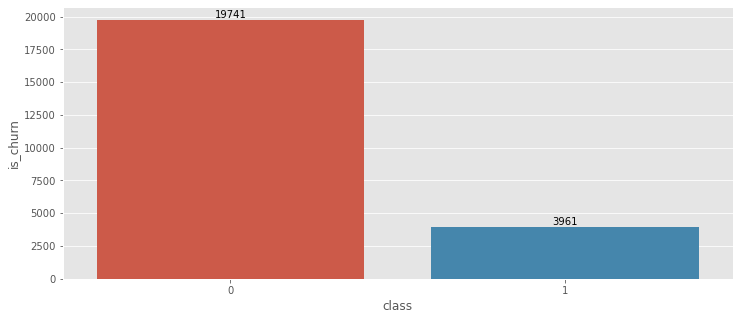

In [65]:
X = df.drop(['client_id', 'product_id', 'is_churn', 'order_id'], axis=1)
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

plot_proportion(y_train)

## Modelagem DecisionTree Baseline

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33860 entries, 0 to 33859
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        33860 non-null  object 
 1   soma_units      33860 non-null  float64
 2   client_id       33860 non-null  int32  
 3   state           33860 non-null  int32  
 4   gender          33860 non-null  int32  
 5   is_churn        33860 non-null  int64  
 6   ano_nasc        33860 non-null  int64  
 7   product_id      33860 non-null  int32  
 8   price           33860 non-null  float64
 9   payment_method  33860 non-null  int32  
 10  installments    33860 non-null  float64
 11  delivery_days   33860 non-null  float64
 12  delivery_state  33860 non-null  int32  
 13  device          33860 non-null  int32  
 14  source          33860 non-null  int32  
 15  category_lv0    33860 non-null  int32  
 16  idade           33860 non-null  int64  
 17  mes_compra      33860 non-null 

In [67]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
bench_metrics, y_pred_proba = predict(dt, X_train, y_train, X_test, y_test, 'Baseline')
bench_metrics

{'accuracy': 0.8308722189407364,
 'precision': 0.6857142857142857,
 'recall': 0.01386481802426343,
 'f1': 0.027180067950169876,
 'name': 'Baseline'}

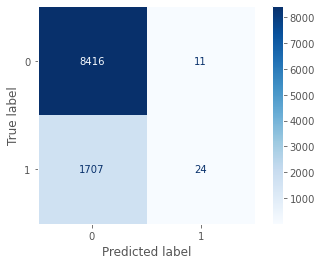

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.5).astype(int), cmap="Blues")
plt.grid(False)

In [69]:
evaluations = pd.DataFrame()
evaluations = append(evaluations, bench_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.830872,0.685714,0.013865,0.02718,Baseline


# Melhorando a métrica da Decision Tree Baseline

## Trabalhando o treshold

In [70]:
best_f1 = 0
best_threshold = 0
for i in range(1, 10):
  f1 = evaluate(y_test, y_pred_proba, threshold=i/10)["f1"]
  if f1 >= best_f1:
    best_threshold = i/10
    best_f1 = f1

threshold_metric = evaluate(y_test, y_pred_proba, threshold=best_threshold)
threshold_metric["name"] = f"threshold_{best_threshold}"
evaluations = append(evaluations, threshold_metric)
evaluations

,accuracy,precision,recall,f1,name
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.830872,0.685714,0.013865,0.027180,Baseline


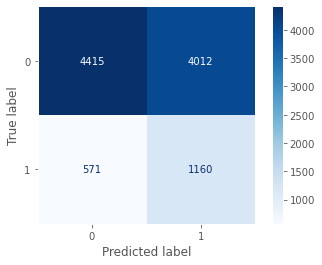

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.2).astype(int), cmap="Blues")
plt.grid(False)

É possivel notar uma melhora significativa em nosso F1, bem como o reflexo disso na matriz de confusão

## Trabalhando com o balanceamento dos dados

### RandomUnderSampling

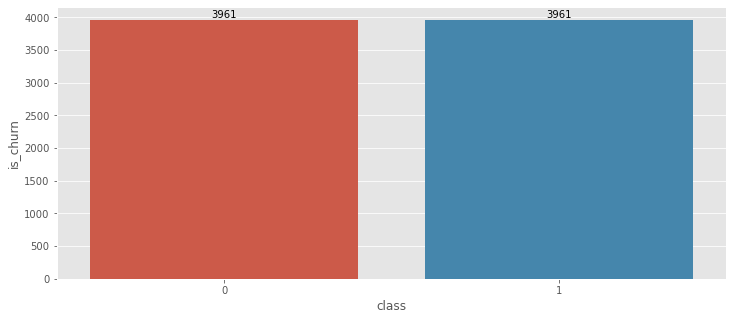

In [72]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
plot_proportion(y_res)

In [73]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
rus_metrics, y_pred_proba = predict(dt, X_res, y_res, X_test, y_test, 'RandomUnderSampling')
evaluations = append(evaluations, rus_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.830872,0.685714,0.013865,0.027180,Baseline


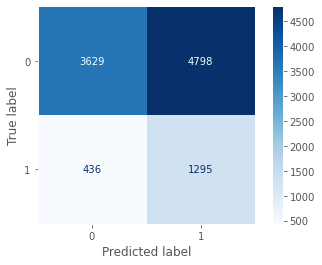

In [74]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

O balanceamento utilizando Random Under Sampling não apresentou um F1  melhor que o teshold de 0.2. O RUS teve seu verdadeiro negativo melhorado, porém teve uma piora em seu falso negativo quando comparado com o treshold de 0.2

### UnderSampling - ENN

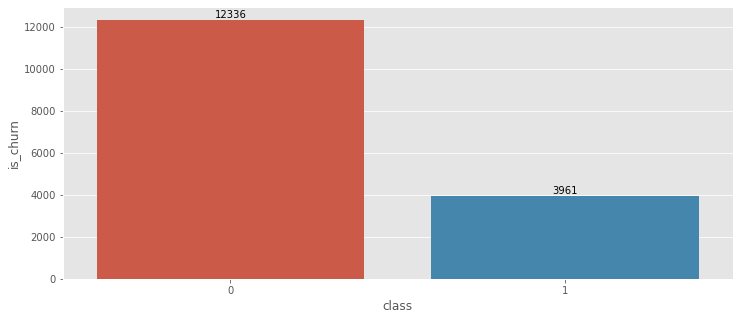

In [75]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=3)
X_res, y_res = enn.fit_resample(X_train, y_train)
plot_proportion(y_res)

In [76]:
enn_metrics, y_pred_proba = predict(dt, X_res, y_res, X_test, y_test, 'EditedNearestNeighbours')
evaluations = append(evaluations, enn_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


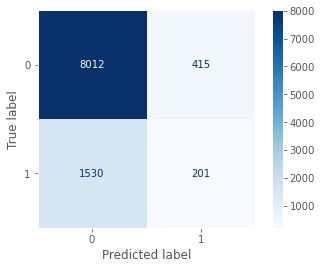

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

ENN apresentou uma metrica tão baixa quanto meu modelo baseline.

### Random Over Sampling

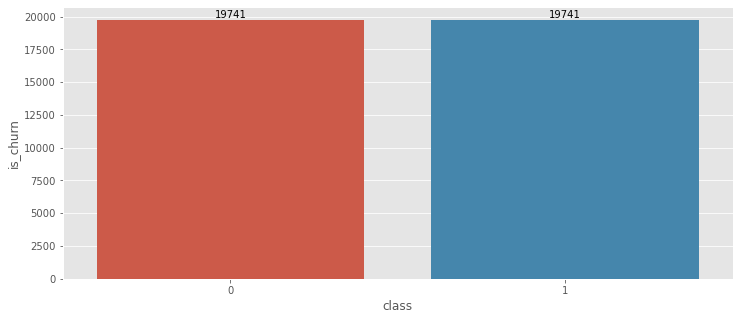

In [78]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
plot_proportion(y_res)

In [79]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
ros_metrics, y_pred_proba = predict(dt, X_res, y_res, X_test, y_test, 'RandomOverSampling')
evaluations = append(evaluations, ros_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


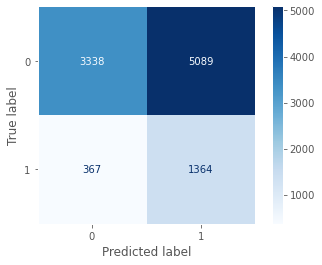

In [80]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

O Random Over Sampling apresentou um F1 melhor que o teshold, porém o valor dos falsos negativos estão elevados.

### SMOTE

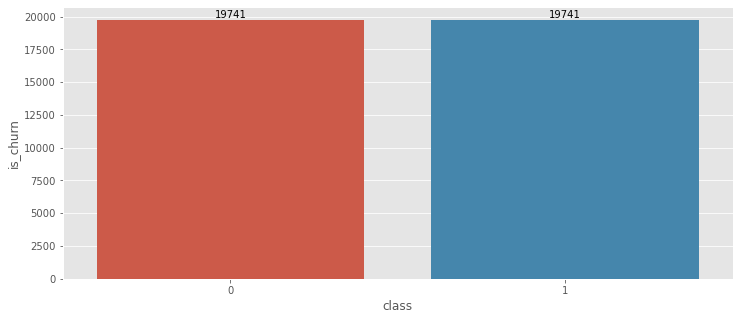

In [81]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
plot_proportion(y_res)

In [82]:
smote_metrics, y_pred_proba = predict(dt, X_res, y_res, X_test, y_test, 'SMOTE')
evaluations = append(evaluations, smote_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.462197,0.191468,0.668977,0.297725,SMOTE
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


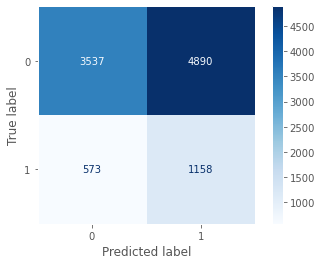

In [83]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

### ADASYN

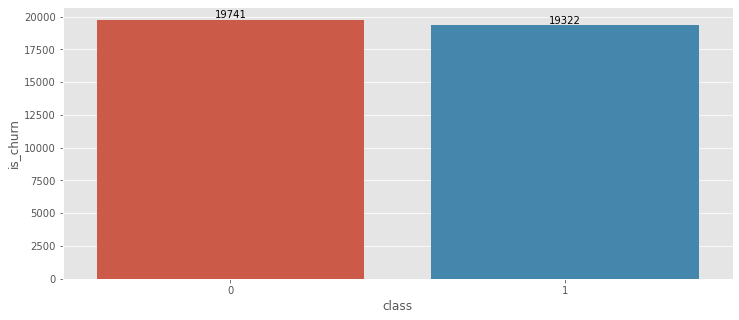

In [84]:
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
plot_proportion(y_res)

In [85]:
adasyn_metrics, y_pred_proba = predict(dt, X_res, y_res, X_test, y_test, "ADASYN")
evaluations = append(evaluations, adasyn_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.462197,0.191468,0.668977,0.297725,SMOTE
0,0.670998,0.215672,0.352975,0.267748,ADASYN
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


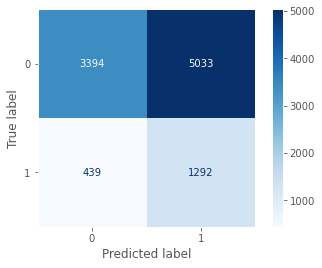

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

### Resultado dos modelos com balanceamento dos dados

In [87]:
evaluations

,accuracy,precision,recall,f1,name
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.462197,0.191468,0.668977,0.297725,SMOTE
0,0.670998,0.215672,0.352975,0.267748,ADASYN
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


Analisando os resultados, levando em conta a métrica F1, vemos que alguns modelos tem desempenho parecidos, o ideal é avaliar junto com o time de negócios, o resultado das matrizes de confunsão, e entender qual seriam as consequencia de termos valores mais elevados para falsos polsitivos e falsos negativos.

# RandomForest baseline

In [88]:
rf = RandomForestClassifier(random_state=42, n_estimators=45)
rf.fit(X_train,y_train)
rf_metric, y_pred_proba = predict(rf, X_train, y_train, X_test, y_test, "RandomForestBaseline")
evaluations = append(evaluations, rf_metric)
evaluations

,accuracy,precision,recall,f1,name
0,0.868773,0.829470,0.289428,0.429122,RandomForestBaseline
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.462197,0.191468,0.668977,0.297725,SMOTE
0,0.670998,0.215672,0.352975,0.267748,ADASYN
0,0.824375,0.306569,0.024263,0.044968,EditedNearestNeighbours
0,0.830872,0.685714,0.013865,0.027180,Baseline


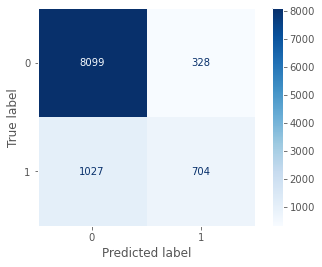

In [89]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

# GridSearch na RandomForest Baseline

In [93]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid = {
    "min_samples_leaf": list(range(2, 9, 3)),
    "max_depth": list(range(1,100,10)),
    "n_estimators": list([100,200,500,1000]),
}

In [95]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

model_gridsearch = GridSearchCV(
  estimator=rf_model,
  param_grid=param_grid,
  scoring='f1',
)

In [96]:
#model_gridsearch.fit(X_train, y_train)

In [97]:
 #print(model_gridsearch.best_params_)

In [102]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth = 51, min_samples_leaf = 2, n_estimators = 200)
rf_model.fit(X_train,y_train)
rf_model_metrics, y_pred_proba = predict(rf_model, X_train, y_train, X_test, y_test, "RandomForestCV")
evaluations = append(evaluations, rf_model_metrics)
evaluations

,accuracy,precision,recall,f1,name
0,0.868773,0.829470,0.289428,0.429122,RandomForestBaseline
0,0.868773,0.829470,0.289428,0.429122,RandomForestROS
0,0.523528,0.221864,0.716349,0.338798,RandomOverSampling
0,0.548829,0.224285,0.670133,0.336086,threshold_0.2
0,0.487202,0.212847,0.744656,0.331065,RandomUnderSampling
0,0.858043,0.916427,0.183709,0.306064,RandomForestROSGridSearch
0,0.858043,0.916427,0.183709,0.306064,RandomForestROSGridSearch
0,0.858043,0.916427,0.183709,0.306064,RandomForestCV
0,0.462197,0.191468,0.668977,0.297725,SMOTE
0,0.670998,0.215672,0.352975,0.267748,ADASYN


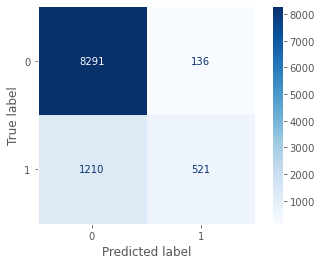

In [101]:
ConfusionMatrixDisplay.from_predictions(y_test, (y_pred_proba >= 0.4).astype(int), cmap="Blues")
plt.grid(False)

# Conclusão

## Foram testados e parametrizados diversos modelos de ML, e verificamos que o que obteve uma métrica melhor foi o modelo base line do randomforest. Alguns dos modelos tiveram uma performance muito baixa e apresentaram uma matriz de confusão não tão agradável. O modelo baseline da randomforest foi o que apresentou a melhor métrica, sendo assim, seria interessante apresentar este modelo para o time de negócios e validar que a performance do modelo agrega valor para o problema de churn dos clientes, sendo possível incentivar clientes que podem dar churn a continuarem utilizando a plataforma da empresa, aumentando assim o número de clientes ativos que realizam compras utilizando a plataforma.